In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import requests, zipfile, StringIO
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# IDEA

**Young people are more likely to use bikes to commute compared to older people.**

# NULL HYPOTHESIS

**The ratio of people aged 21-40 biking on weekends to people aged 21-40 biking on weekdays is _equal_ or _lower_ than the ration of people aged 41-60 biking on weekends to people aged 41-60 biking on weekdays.**

_The hypothesis is going to be tested at 5% significance level (a=0.05)._

$H_{0} : \frac{Bikers21-40_{weekends}}{Bikers21-40_{weekdays}} - \frac{Bikers41-60_{weekends}}{Bikers41-60_{weekdays}} \leq 0$

$H_{a} : \frac{Bikers21-40_{weekends}}{Bikers21-40_{weekdays}} - \frac{Bikers41-60_{weekends}}{Bikers41-60_{weekdays}} > 0$

In [2]:
### A function to download the data: simple bash commands can be run by preceding them with !
### but more complex command lines with variable arguments need to be build as strng and run with os.system
### this code cell does a lot of things: looks for existing files, download a file if none is there, unzips it, moves it.
### you do not have to have a code cell this complicated. 
### As long as 
### 1) your research is reproducible: we can access the same file as you without having to ask you for the file
### 2) and your data is stored in a directory pointed to by the env variable PUIDATA 
### you will be fine. We already explored how to download data in other notebooks!

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [5]:
datestring = '201503'
getCitiBikeCSV(datestring)
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df.head()

file in place, you can continue


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,669,3/1/2015 0:00,3/1/2015 0:11,164,E 47 St & 2 Ave,40.753231,-73.970325,477,W 41 St & 8 Ave,40.756405,-73.990026,21409,Subscriber,1987.0,1
1,750,3/1/2015 0:01,3/1/2015 0:14,258,DeKalb Ave & Vanderbilt Ave,40.689407,-73.968855,436,Hancock St & Bedford Ave,40.682166,-73.953990,19397,Subscriber,1968.0,1
2,663,3/1/2015 0:01,3/1/2015 0:12,497,E 17 St & Broadway,40.737050,-73.990093,477,W 41 St & 8 Ave,40.756405,-73.990026,20998,Customer,NaN,0
3,480,3/1/2015 0:02,3/1/2015 0:10,470,W 20 St & 8 Ave,40.743453,-74.000040,491,E 24 St & Park Ave S,40.740964,-73.986022,21565,Subscriber,1983.0,1
4,1258,3/1/2015 0:02,3/1/2015 0:23,345,W 13 St & 6 Ave,40.736494,-73.997044,473,Rivington St & Chrystie St,40.721101,-73.991925,14693,Subscriber,1970.0,1


In [6]:
# Another way of getting the data.

#datestring = '201503'
#r = requests.get('https://s3.amazonaws.com/tripdata/'+datestring + '-citibike-tripdata.zip')
#z = zipfile.ZipFile(StringIO.StringIO(r.content))

#df= pd.read_csv(z.open(datestring+'-citibike-tripdata.csv'))
#df.head()

In [7]:
df['date'] = pd.to_datetime(df['starttime'])

In [8]:
df['age'] = 2015 - df['birth year']
df = df[['age', 'date']]
df.head()

,age,date
0,28.0,2015-03-01 00:00:00
1,47.0,2015-03-01 00:01:00
2,NaN,2015-03-01 00:01:00
3,32.0,2015-03-01 00:02:00
4,45.0,2015-03-01 00:02:00


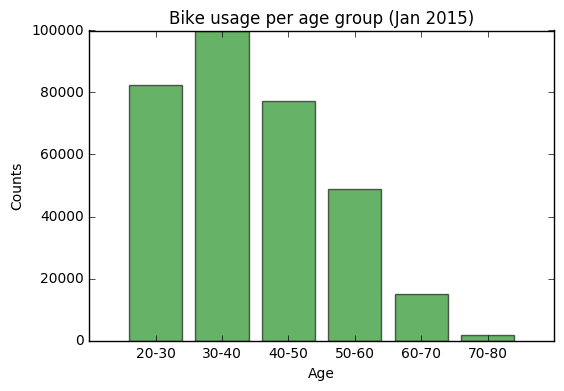

In [9]:
bins = np.arange(20, 90, 10)
df_ages = df.groupby(pd.cut(df.age, bins))
objects = ('20-30', '30-40', '40-50', '50-60', '60-70', '70-80')
y_pos = np.arange(len(objects))
plt.bar(y_pos, df_ages.age.count(), align='center', alpha=0.6, color = 'g')
plt.xticks(y_pos, objects)
plt.xlabel('Age')
plt.ylabel('Counts')
plt.title('Bike usage per age group (Jan 2015)')
plt.show()

## Figure 1:

Shows shows the bike usage by age group (January 2015).

People aged between 30-40 are the group that has checked out more bikes for this particular period.

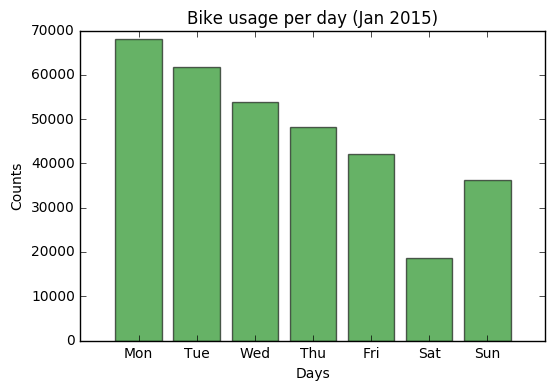

In [10]:
df_weekdays = df.groupby([df['date'].dt.weekday]).count()

objects = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun')
y_pos = np.arange(len(objects))
plt.bar(y_pos, df_weekdays.age, align='center', alpha=0.6, color = 'g')
plt.xticks(y_pos, objects)
plt.xlabel('Days')
plt.ylabel('Counts')
plt.title('Bike usage per day (Jan 2015)')
plt.show()

## Figure 2:

Shows shows the bike usage by day (January 2015).

During weekdays more bikes are checked out, with Saturday being the day with the lower number of checkouts.

In [116]:
young = df[(df.age<41) & (df.age>19)].groupby([df.date.dt.weekday]).count()
error_y=np.sqrt(young)
norm_y = young.sum()

young_weekday = young.age[0:5]
error_y_weekday=np.sqrt(young_weekday)
norm_y_weekday = young_weekday.sum()

young_weekend = young.age[5:7]
error_y_weekend=np.sqrt(young_weekend)
norm_y_weekend = young_weekend.sum()

old = df[(df.age>40) & (df.age<61)].groupby([df.date.dt.weekday]).count()
error_o=np.sqrt(old)
norm_o = old.sum()

old_weekday = old.age[0:5]
error_o_weekday=np.sqrt(old_weekday)
norm_o_weekday = old_weekday.sum()

old_weekend = old.age[5:7].sum()
error_o_weekend=np.sqrt(old_weekend)
norm_o_weekend = old_weekend.sum()

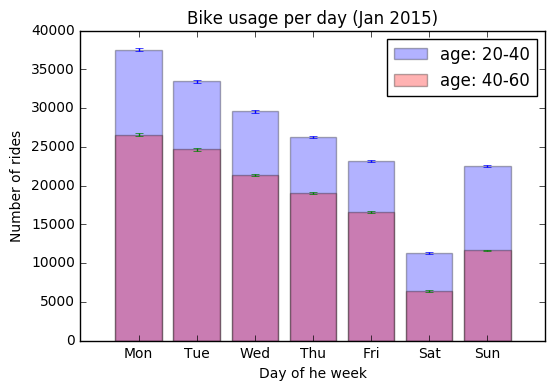

In [111]:
plt.bar(y_pos, young.age, yerr = [error_y.age, error_y.age], align='center', alpha = 0.3, label = 'age: 20-40')
plt.bar(y_pos, old.age, yerr = [error_o.age, error_o.age], align='center', alpha = 0.3, color = 'red', label = 'age: 40-60')
plt.xticks(y_pos, objects)
plt.xlabel('Day of he week')
plt.ylabel('Number of rides')
plt.title('Bike usage per day (Jan 2015)')
plt.legend()

## Figure 3:
Shows the distribution of citibike rides for the two age groups (Absolute values + Statistical errors)

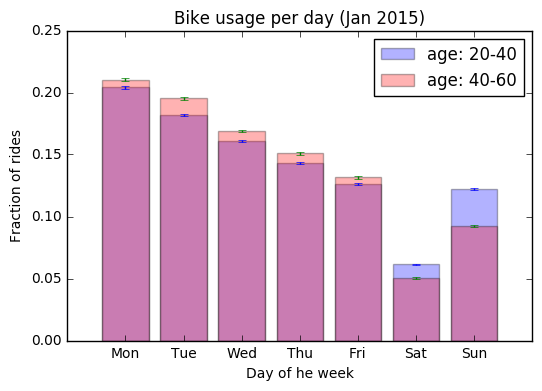

In [112]:
plt.bar(y_pos, young.age/norm_y.age, yerr = [error_y.age/norm_y.age, error_y.age/norm_y.age], 
        align='center', alpha = 0.3, label = 'age: 20-40')
plt.bar(y_pos, old.age/norm_o.age, yerr = [error_o.age/norm_o.age, error_o.age/norm_o.age], 
        align='center', alpha = 0.3, color = 'red', label = 'age: 40-60')
plt.xticks(y_pos, objects)
plt.xlabel('Day of he week')
plt.ylabel('Fraction of rides')
plt.title('Bike usage per day (Jan 2015)')
plt.legend()

## Figure 4:
Shows the distribution of citibike rides for the two age groups (Normalized values + Statistical errors)

In [113]:
week_y = norm_y_weekday * 1.0 / norm_y
weekend_y = norm_y_weekend * 1.0 / norm_y
eweek_y = np.sqrt(np.sum(error_y_weekday**2.0)) / norm_y
eweekend_y = np.sqrt(np.sum(error_y_weekend**2.0)) / norm_y

week_o = norm_o_weekday * 1.0 / norm_o
weekend_o = norm_o_weekend * 1.0 / norm_o
eweek_o = np.sqrt(np.sum(error_o_weekday**2)) / norm_o
eweekend_o = np.sqrt(np.sum(error_o_weekend**2)) / norm_o

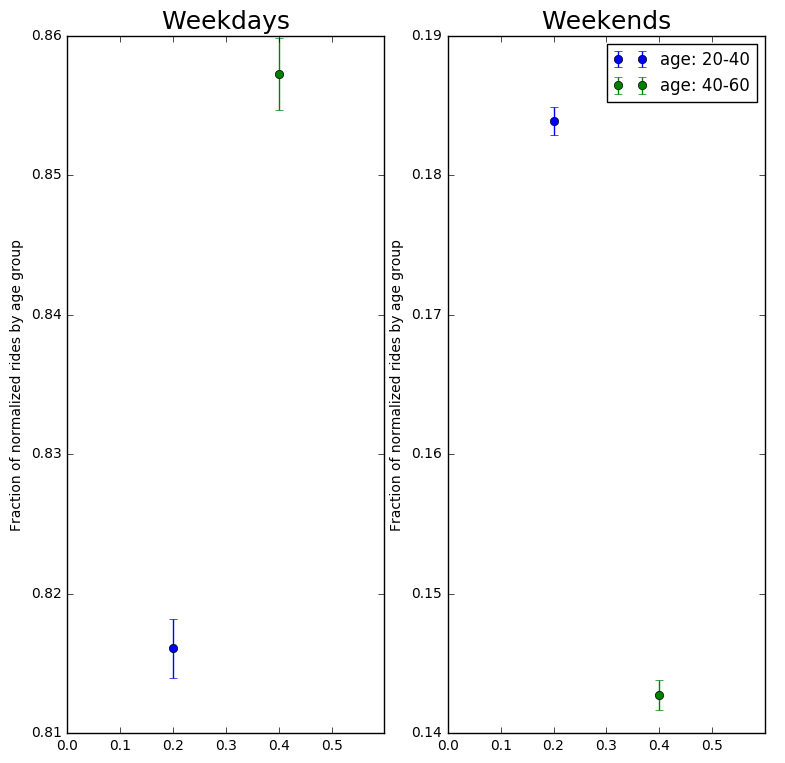

In [114]:
plt.figure(figsize = (9,9))
plt.subplot(121)
plt.title('Weekdays', fontsize=18)
plt.ylabel('Fraction of normalized rides by age group')
plt.errorbar([0.2], [week_y.age],yerr=[eweek_y.age], fmt = 'o', color = 'b', label = 'age: 20-40')
plt.errorbar([0.4], [week_o.age],yerr=[eweek_o.age], fmt = 'o', color = 'g', label = 'age: 40-60')
plt.xlim([0,0.6])
plt.subplot(122)
plt.title('Weekends', fontsize=18)
plt.ylabel('Fraction of normalized rides by age group')
plt.errorbar([0.2], [weekend_y.age],yerr=[eweekend_y.age], fmt = 'o', color = 'b', label = 'age: 20-40')
plt.errorbar([0.4], [weekend_o.age],yerr=[eweekend_o.age], fmt = 'o', color = 'g', label = 'age: 40-60')
plt.xlim([0,0.6])
plt.ylim([0.14, 0.19])
plt.legend()

## Figure 5:

Shows shows the fraction of normalized rides by age group, for weekdays (left) and weekends (right).

In [68]:
# defining the functions that calculate the statistics
# the lambda style definition is NOT APPROVED BY PEP8 and you should avoind it
# but I am putting it here since you may encounter it in your coding life.
# confront the equation in the markdown cell above with these function to understand as they work

p = lambda p0, p1, n0, n1: (p0 * n0 + p1 * n1) / (n0 + n1)
se = lambda p, n0, n1: np.sqrt(p * (1 - p) * (1.0 / n0 + 1.0 / n1)) #standard error
zscore = lambda p0, p1, s : (p0 - p1) / s

# calculations

sp_stdev_oy = se(p(weekend_y, weekend_o, norm_y, norm_o), norm_y, norm_o)
z = zscore(weekend_y, weekend_o, sp_stdev_oy)
print ("The z statistics is %.2f"%z.age) 

The z statistics is 30.17


Thhe **z-score** calculated above is **30.17**. This value is by far higher than the minimun value of 3.4 usually shown on z-tables. For this minimum value the p-value is **0.0003** < 0.05, which gives us enough evidence to reject $H_{0}$ that young people are less likely to commute by bike than older people in significance level a=0.05

#### In the following section I am testing the robustness of the test during a summer month.

In [69]:
datestring = '201507'
getCitiBikeCSV(datestring)

file in place, you can continue


In [70]:
df_summer = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df_summer['date'] = pd.to_datetime(df_summer.starttime)
df_summer.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,732,7/1/2015 00:00:03,7/1/2015 00:12:16,489,10 Ave & W 28 St,40.750664,-74.001768,368,Carmine St & 6 Ave,40.730386,-74.002150,18669,Subscriber,1970.0,1,2015-07-01 00:00:03
1,322,7/1/2015 00:00:06,7/1/2015 00:05:29,304,Broadway & Battery Pl,40.704633,-74.013617,3002,South End Ave & Liberty St,40.711512,-74.015756,14618,Subscriber,1984.0,1,2015-07-01 00:00:06
2,790,7/1/2015 00:00:17,7/1/2015 00:13:28,447,8 Ave & W 52 St,40.763707,-73.985162,358,Christopher St & Greenwich St,40.732916,-74.007114,18801,Subscriber,1992.0,1,2015-07-01 00:00:17
3,1228,7/1/2015 00:00:23,7/1/2015 00:20:51,490,8 Ave & W 33 St,40.751551,-73.993934,250,Lafayette St & Jersey St,40.724561,-73.995653,19137,Subscriber,1990.0,1,2015-07-01 00:00:23
4,1383,7/1/2015 00:00:44,7/1/2015 00:23:48,327,Vesey Pl & River Terrace,40.715338,-74.016584,72,W 52 St & 11 Ave,40.767272,-73.993929,15808,Subscriber,1988.0,1,2015-07-01 00:00:44


In [71]:
df_summer['age'] = 2015 - df_summer['birth year']
df_summer = df_summer[['age', 'date']]
df_summer.head()

,age,date
0,45.0,2015-07-01 00:00:03
1,31.0,2015-07-01 00:00:06
2,23.0,2015-07-01 00:00:17
3,25.0,2015-07-01 00:00:23
4,27.0,2015-07-01 00:00:44


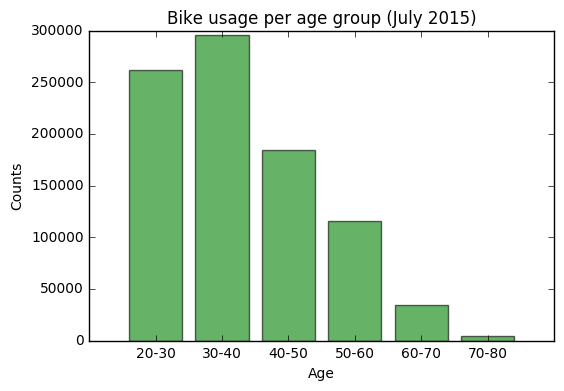

In [72]:
bins = np.arange(20, 90, 10)
df_ages = df_summer.groupby(pd.cut(df_summer.age, bins))
objects = ('20-30', '30-40', '40-50', '50-60', '60-70', '70-80')
y_pos = np.arange(len(objects))
plt.bar(y_pos, df_ages.age.count(), align='center', alpha=0.6, color = 'g')
plt.xticks(y_pos, objects)
plt.xlabel('Age')
plt.ylabel('Counts')
plt.title('Bike usage per age group (July 2015)')
plt.show()

## Figure 6:

Shows shows the bike usage by age group (July 2015).

People aged between 30-40 are the group that has checked out more bikes for this particular period.

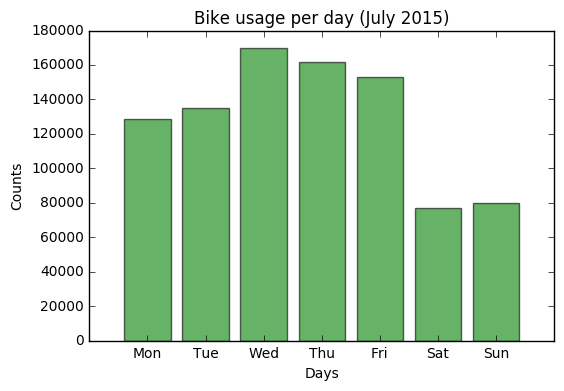

In [73]:
df_weekdays = df_summer.groupby([df_summer['date'].dt.weekday]).count()

objects = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun')
y_pos = np.arange(len(objects))
plt.bar(y_pos, df_weekdays.age, align='center', alpha=0.6, color = 'g')
plt.xticks(y_pos, objects)
plt.xlabel('Days')
plt.ylabel('Counts')
plt.title('Bike usage per day (July 2015)')
plt.show()

## Figure 7:

Shows shows the bike usage by day (July 2015).

During weekdays more bikes are checked out, with Saturday being the day with the lower number of checkouts.

In [102]:
young = df_summer[(df_summer.age<41) & (df_summer.age>19)].groupby([df_summer.date.dt.weekday]).count()
error_y=np.sqrt(young.age)
norm_y_summer = young.age.sum()

young_weekday = young.age[0:5]
error_y_weekday=np.sqrt(young_weekday)
norm_y_weekday = young_weekday.sum()

young_weekend = young.age[5:7]
error_y_weekend=np.sqrt(young_weekend)
norm_y_weekend = young_weekend.sum()

old = df_summer[(df_summer.age>40) & (df_summer.age<61)].groupby([df_summer.date.dt.weekday]).count()
error_o=np.sqrt(old.age)
norm_o_summer = old.age.sum()

old_weekday = old.age[0:5]
error_o_weekday=np.sqrt(old_weekday)
norm_o_weekday = old_weekday.sum()

old_weekend = old.age[5:7].sum()
error_o_weekend=np.sqrt(old_weekend)
norm_o_weekend = old_weekend.sum()

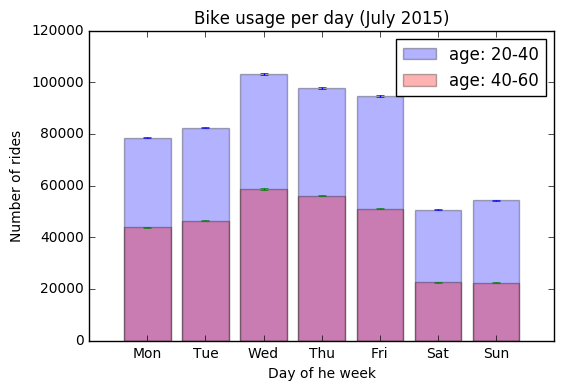

In [90]:
plt.bar(y_pos, young.age, yerr = [error_y, error_y], align='center', alpha = 0.3, label = 'age: 20-40')
plt.bar(y_pos, old.age, yerr = [error_o, error_o], align='center', alpha = 0.3, color = 'red', label = 'age: 40-60')
plt.xticks(y_pos, objects)
plt.xlabel('Day of he week')
plt.ylabel('Number of rides')
plt.title('Bike usage per day (July 2015)')
plt.legend()

## Figure 8:
Shows the distribution of citibike rides for the two age groups (Absolute values + Statistical errors) (July 2015)

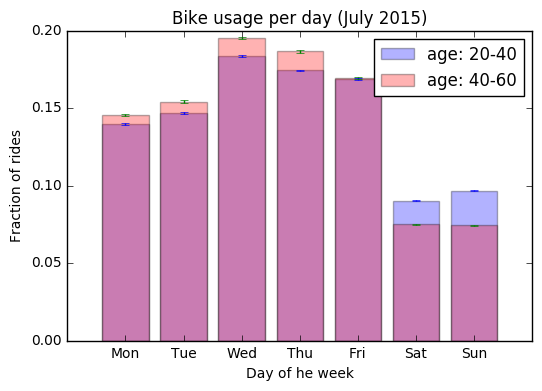

In [103]:
plt.bar(y_pos, young.age/norm_y, yerr = [error_y/norm_y_summer, error_y/norm_y_summer], 
        align='center', alpha = 0.3, label = 'age: 20-40')
plt.bar(y_pos, old.age/norm_o, yerr = [error_o/norm_o_summer, error_o/norm_o_summer], 
        align='center', alpha = 0.3, color = 'red', label = 'age: 40-60')
plt.xticks(y_pos, objects)
plt.xlabel('Day of he week')
plt.ylabel('Fraction of rides')
plt.title('Bike usage per day (July 2015)')
plt.legend()

## Figure 9:
Shows the distribution of citibike rides for the two age groups (Normalized values + Statistical errors) (July 2015)

In [105]:
week_y_summer = norm_y_weekday * 1.0 / norm_y_summer
weekend_y_summer = norm_y_weekend * 1.0 / norm_y_summer
eweek_y_summer = np.sqrt(np.sum(error_y_weekday**2.0)) / norm_y_summer
eweekend_y_summer = np.sqrt(np.sum(error_y_weekend**2.0)) / norm_y_summer

week_o_summer = norm_o_weekday * 1.0 / norm_o_summer
weekend_o_summer = norm_o_weekend * 1.0 / norm_o_summer
eweek_o_summer = np.sqrt(np.sum(error_o_weekday**2)) / norm_o_summer
eweekend_o_summer = np.sqrt(np.sum(error_o_weekend**2)) / norm_o_summer

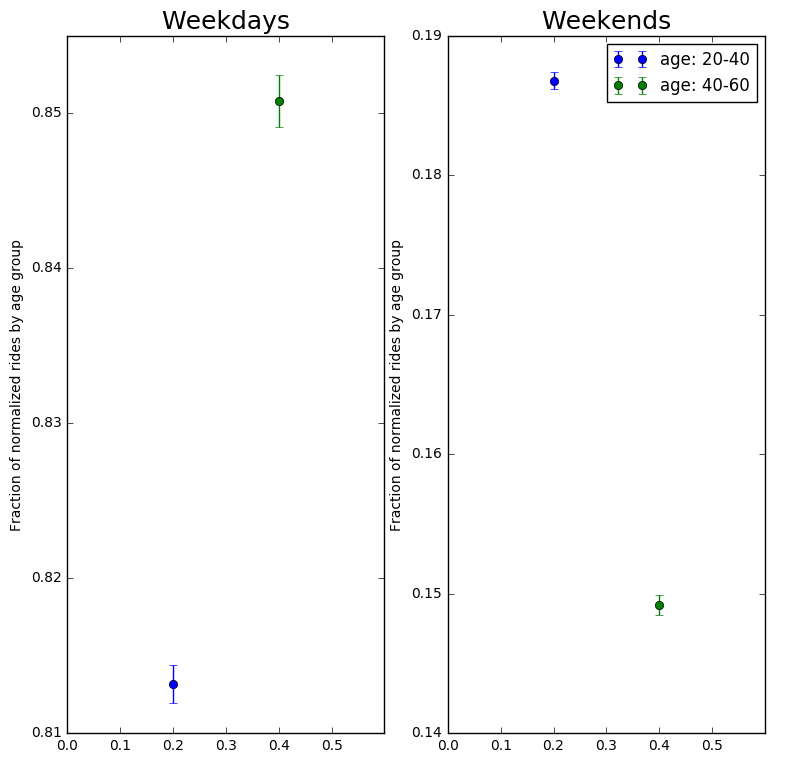

In [106]:
plt.figure(figsize = (9,9))
plt.subplot(121)
plt.title('Weekdays', fontsize=18)
plt.ylabel('Fraction of normalized rides by age group')
plt.errorbar([0.2], [week_y_summer],yerr=[eweek_y_summer], fmt = 'o', color = 'b', label = 'age: 20-40')
plt.errorbar([0.4], [week_o_summer],yerr=[eweek_o_summer], fmt = 'o', color = 'g', label = 'age: 40-60')
plt.xlim([0,0.6])
plt.subplot(122)
plt.title('Weekends', fontsize=18)
plt.ylabel('Fraction of normalized rides by age group')
plt.errorbar([0.2], [weekend_y_summer],yerr=[eweekend_y_summer], fmt = 'o', color = 'b', label = 'age: 20-40')
plt.errorbar([0.4], [weekend_o_summer],yerr=[eweekend_o_summer], fmt = 'o', color = 'g', label = 'age: 40-60')
plt.xlim([0,0.6])
plt.ylim([0.14, 0.19])
plt.legend()

## Figure 10:

Shows shows the fraction of normalized rides by age group, for weekdays (left) and weekends (right) (July 2015)

In [107]:
sp_stdev_summer = se(p(weekend_y_summer, weekend_o_summer, norm_y_summer, norm_o_summer), norm_y_summer, norm_o_summer)
z_summer = zscore(weekend_y_summer, weekend_o_summer, sp_stdev_summer)
print ("The z statistics is %.2f"%z_summer) 

The z statistics is 43.92


Again the z-score is a lot higher than 3.84, suggesting rejection of the null hypothesis. The statistic is robust for different seasons of the year. 

#### Now let's check the effect size.

In [108]:
r = lambda z, n0, n1 : z / np.sqrt(n0+n0)
h = lambda p0, p1: 2 * (np.arcsin(np.sqrt(p0)) - np.arcsin(np.sqrt(p1)))

In [121]:
r_spring = r(z, norm_y, norm_o)
r_summer = r(z_summer, norm_y_summer, norm_o_summer)
print (r_spring.age, r_summer)

0.0497637339385 0.0414498678567


In [124]:
h_spring = h(weekend_y, weekend_o)
h_summer = h(weekend_y_summer, weekend_o_summer)
print (h_spring.age, h_summer)

0.111534192996 0.100722854006


As a rule of thumb Cohen's h values less than 0.2 indicate small effect size. In the two ratio tested, the effect size seems to be very small, and more specifically it is slightly smaller for July's data.